### LDA

In [1]:
library(tidyverse)
library(MASS)
library(pROC)

#install.packages("pracma")
library("pracma")

#install.packages('dummies')
library(dummies)

install.packages("splitTools")
library(splitTools)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘pracma’

The following object is masked from ‘package:purrr’:

    cross

dummies-1.5.6 provided by Decision Patterns

Up

In [2]:
#data <- readRDS("../data/ATAC_predictions_train_XX_predict_XX/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")
data <- readRDS(snakemake@input[["input_predictions"]])


head(data)

,sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr1_641,chr11_241,chr1_642,chr11_242,chr1_643,chr11_243,chr1_644,chr11_244,chr1_645,chr11_245
V1,PGDX16568P,0.7621097,-0.8032188,0.6402487,-0.8688929,-0.4792134,-0.5096581,0.02594817,0.7295906,0.7738027,...,0.7892817,-0.58144968,2.269884,1.434826,1.864355,1.3740736,2.528704,1.290647,1.751823,0.5048315
V2,PGDX16569P,0.7057109,-0.8227554,0.7868749,-1.0407754,-0.9284673,-0.4139074,-0.16594560,0.7765621,0.5761691,...,1.1009683,-0.56631698,1.345187,1.221831,1.077722,0.8033964,2.100717,1.630854,2.112455,0.6632617
V3,PGDX16570P,0.4891340,-1.1448217,0.9478602,-1.0930696,-0.5115270,-0.7552269,-0.48824613,0.9537215,0.6624865,...,0.2534565,-0.03052315,1.995378,1.035342,1.574349,1.5501505,2.642246,1.770297,1.549006,0.4566185
V4,PGDX16571P,0.6882727,-0.8585679,0.6248431,-0.8310281,-0.5335804,-0.5125528,-0.34185944,0.9281618,0.4768828,...,0.8794347,-0.77891451,2.046281,1.164917,1.178645,1.7902343,2.372654,2.006993,2.766960,0.8190837
V5,PGDX16579P,0.5801896,-1.1674832,0.7883376,-1.0498406,-1.2475692,-0.7345196,-0.18778863,0.2546093,0.2920616,...,1.9551742,-0.02820894,2.241780,1.341119,1.242510,2.5053049,2.943284,1.573387,2.393389,0.7442627
V6,PGDX16580P,0.6831409,-0.8712906,0.7199476,-1.1853489,-0.8520159,-0.6829992,-0.35499242,0.8598551,0.3870744,...,1.4391357,-0.96977934,2.122007,1.129329,1.421938,1.4859774,2.437050,2.357834,1.913518,0.1663542


In [3]:
dim(data)

[1]  424 1000

In [4]:
sample_types <- read.table(snakemake@input[["input_sample_types"]], header = F, sep = " ")
#sample_types <- read.table("../data/sample_types.txt", header = F, sep = " ")

colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [5]:
data <- merge(data, sample_types, by="sample")
head(data)
#data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr11_241,chr1_642,chr11_242,chr1_643,chr11_243,chr1_644,chr11_244,chr1_645,chr11_245,sample_type
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,-0.1350057,1.396762,0.6673027,1.416659,2.6568717,2.563044,1.238451,1.871482,0.5087295,Gastric_cancer
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-0.2161901,1.363826,0.9943344,1.076290,1.5840497,2.861480,1.069156,1.522159,1.0665973,Gastric_cancer
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,-0.7208022,0.211068,0.2501289,0.225827,0.1939239,2.342276,1.931427,0.936926,1.0732974,Gastric_cancer
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,-0.2583754,1.752366,1.4272521,1.330554,1.6282278,2.657614,1.350528,1.542564,0.8510458,Gastric_cancer
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,0.1075004,2.133680,0.9742325,1.423943,1.0227989,2.750681,1.648421,1.503545,1.1320816,Ovarian_Cancer
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,-0.9774666,1.296159,0.6598228,1.344413,1.2591127,2.348759,1.617112,1.336589,0.3253446,Ovarian_Cancer


In [6]:
head(data)

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr11_241,chr1_642,chr11_242,chr1_643,chr11_243,chr1_644,chr11_244,chr1_645,chr11_245,sample_type
PGDX10344P1,0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,...,-0.1350057,1.396762,0.6673027,1.416659,2.6568717,2.563044,1.238451,1.871482,0.5087295,Gastric_cancer
PGDX10346P1,1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,...,-0.2161901,1.363826,0.9943344,1.076290,1.5840497,2.861480,1.069156,1.522159,1.0665973,Gastric_cancer
PGDX10349P1,0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,...,-0.7208022,0.211068,0.2501289,0.225827,0.1939239,2.342276,1.931427,0.936926,1.0732974,Gastric_cancer
PGDX10351P1,1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,...,-0.2583754,1.752366,1.4272521,1.330554,1.6282278,2.657614,1.350528,1.542564,0.8510458,Gastric_cancer
PGDX10566P,0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,...,0.1075004,2.133680,0.9742325,1.423943,1.0227989,2.750681,1.648421,1.503545,1.1320816,Ovarian_Cancer
PGDX10567P,0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,...,-0.9774666,1.296159,0.6598228,1.344413,1.2591127,2.348759,1.617112,1.336589,0.3253446,Ovarian_Cancer


In [7]:
#data <- data %>% dplyr::select(-sample_type)
data <- data %>% dplyr::select(-sample)

In [8]:
head(data)

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr11_241,chr1_642,chr11_242,chr1_643,chr11_243,chr1_644,chr11_244,chr1_645,chr11_245,sample_type
0.28476325,-0.8212573,1.0277500,-0.7094983,-0.2327985,-0.7836319,0.01979819,0.2624251,0.3128992,1.45146500,...,-0.1350057,1.396762,0.6673027,1.416659,2.6568717,2.563044,1.238451,1.871482,0.5087295,Gastric_cancer
1.28471727,-0.8295661,1.0145149,-0.6213053,-0.8143027,-0.6479755,-0.06975614,0.9264024,0.4895216,0.04814456,...,-0.2161901,1.363826,0.9943344,1.076290,1.5840497,2.861480,1.069156,1.522159,1.0665973,Gastric_cancer
0.07110482,-1.0079115,0.3347017,-1.1303365,-0.8177276,-0.9202015,-0.08484151,0.5183954,2.2808829,1.33462998,...,-0.7208022,0.211068,0.2501289,0.225827,0.1939239,2.342276,1.931427,0.936926,1.0732974,Gastric_cancer
1.36298501,-1.4848879,0.4225454,-1.3192129,-0.7097136,-0.4653093,-0.42147744,0.9729417,0.5944980,0.97671516,...,-0.2583754,1.752366,1.4272521,1.330554,1.6282278,2.657614,1.350528,1.542564,0.8510458,Gastric_cancer
0.40245603,-1.0782760,1.2759516,-0.8646247,-0.5192562,-0.8555661,-0.22999396,0.7699482,0.4825674,0.76308429,...,0.1075004,2.133680,0.9742325,1.423943,1.0227989,2.750681,1.648421,1.503545,1.1320816,Ovarian_Cancer
0.97825189,-0.6787169,1.0934262,-0.1749540,-0.6319351,-0.7585842,0.22653017,0.5994301,0.6407291,0.64706533,...,-0.9774666,1.296159,0.6598228,1.344413,1.2591127,2.348759,1.617112,1.336589,0.3253446,Ovarian_Cancer


In [9]:
unique(data$sample_type)

[1] Gastric_cancer    Ovarian_Cancer    Lung_Cancer       Healthy          
[5] Bile_Duct_Cancer  Pancreatic_Cancer Duodenal_Cancer   Breast_Cancer    
[9] Colorectal_Cancer
9 Levels: Bile_Duct_Cancer Breast_Cancer Colorectal_Cancer ... Pancreatic_Cancer

In [10]:
data %>% group_by(sample_type) %>% summarize(n = n())

sample_type,n
Bile_Duct_Cancer,25
Breast_Cancer,54
Colorectal_Cancer,26
Duodenal_Cancer,1
Gastric_cancer,27
Healthy,194
Lung_Cancer,35
Ovarian_Cancer,28
Pancreatic_Cancer,34


In [11]:
dim(data)

[1]  424 1000

In [12]:
data <-subset(data, sample_type != "Duodenal_Cancer")

In [13]:
dim(data)

[1]  423 1000

In [14]:
unique(data$sample_type)

[1] Gastric_cancer    Ovarian_Cancer    Lung_Cancer       Healthy          
[5] Bile_Duct_Cancer  Pancreatic_Cancer Breast_Cancer     Colorectal_Cancer
9 Levels: Bile_Duct_Cancer Breast_Cancer Colorectal_Cancer ... Pancreatic_Cancer

In [15]:
data %>% group_by(sample_type) %>% summarize(n = n())

sample_type,n
Bile_Duct_Cancer,25
Breast_Cancer,54
Colorectal_Cancer,26
Gastric_cancer,27
Healthy,194
Lung_Cancer,35
Ovarian_Cancer,28
Pancreatic_Cancer,34


In [16]:
data$sample_type <- as.factor(data$sample_type)

In [17]:
levels(data$sample_type)

[1] "Bile_Duct_Cancer"  "Breast_Cancer"     "Colorectal_Cancer"
[4] "Duodenal_Cancer"   "Gastric_cancer"    "Healthy"          
[7] "Lung_Cancer"       "Ovarian_Cancer"    "Pancreatic_Cancer"

In [18]:
data = data %>% droplevels("Duodenal_Cancer")

In [19]:
levels(data$sample_type)

[1] "Bile_Duct_Cancer"  "Breast_Cancer"     "Colorectal_Cancer"
[4] "Gastric_cancer"    "Healthy"           "Lung_Cancer"      
[7] "Ovarian_Cancer"    "Pancreatic_Cancer"

In [25]:
cross_validation <- function(dataset, k_inner_cv, k_outer_cv){
    
    y_all <- dataset$sample_type
    classes <- unique(y_all)
    return_tibble <- tibble(observed = rep(y_all, k_outer_cv), 
                            CV_rep = rep(1:k_outer_cv, each=nrow(dataset)))
    
    for(class in 1:length(unique(y_all))){
    y <- ifelse(y_all==classes[class], 1, 0)
    message(y)
    return_vector_for_class <- c()
    
        for (i in 1:k_outer_cv){ # repeated Cross-validation loop
            set.seed(i)
            #cvfolds <- cut(1:nrow(data), breaks = k_inner_cv, labels = F)
            folds <- create_folds(y, k = k_inner_cv)
            #cvfolds <- sample(cvfolds)

            predicted <- rep(NA, nrow(dataset))
                                
            for (fold in folds){
                #rows      <- which(cvfolds==n)
                testdata  <- dataset[-fold,]
                testdata  <- testdata %>% dplyr::select(-sample_type)
                traindata <- dataset[fold,]
                traindata$sample_type <- ifelse(traindata$sample_type == classes[class], 1, 0)


                fit       <- lda(sample_type ~ ., data=traindata, family = "binomial")
                tmp <- predict(fit, testdata)
                tmp <- tmp$posterior[,2]
                predicted[-fold] <- tmp
                }
            
            return_vector_for_class <- c(return_vector_for_class, predicted)
        }       
        return_tibble <- cbind(return_tibble, tibble("{classes[class]}_pred" := return_vector_for_class))
    }
    
                        
    return(return_tibble)
}

In [26]:
k_outer_cv = 10
results <- cross_validation(data, k_inner_cv = 10, k_outer_cv = k_outer_cv)

111100000000000000000011111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Warning message in lda.default(x, grouping, ...):
“variables are collinear”Warning message in lda.default(x, grouping, ...):
“variables are collinear”Warning message in lda.default(x, grouping, ...):
“variables are collinear”Warning message in lda.default(x, grouping, ...):
“variables are collinear”Warning message in lda.default(x, grouping, ...):
“variables are collinear”Warning message in lda.default(x, grouping, ...):
“variables are collinear”Warning message in lda.default(x, grouping, ...):
“variables are collinear”Warning message in lda.default(x, grouping, ...):
“

In [28]:
head(results)

observed,CV_rep,Gastric_cancer_pred,Ovarian_Cancer_pred,Lung_Cancer_pred,Healthy_pred,Bile_Duct_Cancer_pred,Pancreatic_Cancer_pred,Breast_Cancer_pred,Colorectal_Cancer_pred
Gastric_cancer,1,1.355055e-04,3.350624e-04,1.951443e-06,0.07215735,1.331574e-06,2.467616e-03,2.618548e-02,3.426147e-09
Gastric_cancer,1,7.679557e-04,1.225125e-08,5.202109e-04,0.90744929,1.043617e-08,1.046783e-05,3.523956e-05,1.244277e-07
Gastric_cancer,1,9.971083e-07,5.306996e-06,2.732940e-06,0.09856908,6.847001e-02,9.298745e-01,5.721901e-07,1.824309e-05
Gastric_cancer,1,2.406842e-04,1.070266e-06,3.426210e-05,0.98795817,1.151474e-07,5.756025e-07,3.076165e-04,1.023627e-04
Ovarian_Cancer,1,2.075268e-05,2.328988e-03,1.649403e-02,0.63145035,4.334768e-07,8.511870e-06,1.469839e-02,5.328265e-06
Ovarian_Cancer,1,4.670201e-06,9.545087e-01,3.118295e-06,0.85401848,7.805162e-04,1.067010e-03,4.490446e-04,1.414525e-10


In [35]:
saveRDS(results, file = snakemake@output[["LDA_output"]])

ERROR: Error in saveRDS(results, file = snakemake@output[["LDA_output"]]): object 'snakemake' not found


In [30]:
for ( col in 1:ncol(results)){
    colnames(results)[col] <-  sub("_pred", "", colnames(results)[col])
}
head(results)

observed,CV_rep,Gastric_cancer,Ovarian_Cancer,Lung_Cancer,Healthy,Bile_Duct_Cancer,Pancreatic_Cancer,Breast_Cancer,Colorectal_Cancer
Gastric_cancer,1,1.355055e-04,3.350624e-04,1.951443e-06,0.07215735,1.331574e-06,2.467616e-03,2.618548e-02,3.426147e-09
Gastric_cancer,1,7.679557e-04,1.225125e-08,5.202109e-04,0.90744929,1.043617e-08,1.046783e-05,3.523956e-05,1.244277e-07
Gastric_cancer,1,9.971083e-07,5.306996e-06,2.732940e-06,0.09856908,6.847001e-02,9.298745e-01,5.721901e-07,1.824309e-05
Gastric_cancer,1,2.406842e-04,1.070266e-06,3.426210e-05,0.98795817,1.151474e-07,5.756025e-07,3.076165e-04,1.023627e-04
Ovarian_Cancer,1,2.075268e-05,2.328988e-03,1.649403e-02,0.63145035,4.334768e-07,8.511870e-06,1.469839e-02,5.328265e-06
Ovarian_Cancer,1,4.670201e-06,9.545087e-01,3.118295e-06,0.85401848,7.805162e-04,1.067010e-03,4.490446e-04,1.414525e-10


## AUC calculation with pROC package == One vs. one

In [31]:
rocs <- list()
list_names <- paste0("CV_rep_", 1:k_outer_cv)
for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i) %>% dplyr::select(-c(CV_rep, observed))
    roc <- multiclass.roc(response = data$sample_type, predictor = res_CV)
    rocs[[i]] <- roc
}
names(rocs) <- c(list_names)

paste0("The AUC of the first CV repetition: ", rocs[[1]]$auc)

aucs <- c()
for (i in 1:length(rocs)){
    aucs <- c(aucs, rocs[[i]]$auc) 
}

paste0("The mean AUC of all the CV repetitions: ", mean(aucs))

[1] "The AUC of the first CV repetition: 0.686554114637149"

[1] "The mean AUC of all the CV repetitions: 0.685172520679143"

## AUC calculation with functions == One vs. one (source: https://www.datascienceblog.net/post/machine-learning/performance-measures-multi-class-problems/)

In [32]:
# run only for the first CV repetition to check that we get the same number

res_CV <- data.frame(results %>% filter(CV_rep == 1) %>% dplyr::select(-c(CV_rep, observed)))
head(res_CV)

Gastric_cancer,Ovarian_Cancer,Lung_Cancer,Healthy,Bile_Duct_Cancer,Pancreatic_Cancer,Breast_Cancer,Colorectal_Cancer
1.355055e-04,3.350624e-04,1.951443e-06,0.07215735,1.331574e-06,2.467616e-03,2.618548e-02,3.426147e-09
7.679557e-04,1.225125e-08,5.202109e-04,0.90744929,1.043617e-08,1.046783e-05,3.523956e-05,1.244277e-07
9.971083e-07,5.306996e-06,2.732940e-06,0.09856908,6.847001e-02,9.298745e-01,5.721901e-07,1.824309e-05
2.406842e-04,1.070266e-06,3.426210e-05,0.98795817,1.151474e-07,5.756025e-07,3.076165e-04,1.023627e-04
2.075268e-05,2.328988e-03,1.649403e-02,0.63145035,4.334768e-07,8.511870e-06,1.469839e-02,5.328265e-06
4.670201e-06,9.545087e-01,3.118295e-06,0.85401848,7.805162e-04,1.067010e-03,4.490446e-04,1.414525e-10


In [33]:
compute.A.conditional <- function(pred.matrix, i, j, ref.outcome) {
    # computes A(i|j), the probability that a randomly 
    # chosen member of class j has a lower estimated probability (or score) 
    # of belonging to class i than a randomly chosen member of class i

    # select predictions of class members
    i.idx <- which(ref.outcome == i)
    j.idx <- which(ref.outcome == j)
    pred.i <- pred.matrix[i.idx, i] # p(G = i) assigned to class i observations
    pred.j <- pred.matrix[j.idx, i] # p(G = i) assigned to class j observations
    all.preds <- c(pred.i, pred.j)
    classes <- c(rep(i, length(pred.i)), rep(j, length(pred.j)))
    o <- order(all.preds)
    classes.o <- classes[o]
    # Si: sum of ranks from class i observations
    Si <- sum(which(classes.o == i))
    ni <- length(i.idx)
    nj <- length(j.idx)
    # calculate A(i|j)
    A <- (Si - ((ni * (ni + 1))/2)) / (ni * nj)
    return(A)
}

multiclass.auc <- function(pred.matrix, ref.outcome) {
    labels <- colnames(pred.matrix)
    A.ij.cond <- utils::combn(labels, 2, function(x, pred.matrix, ref.outcome) {x
        i <- x[1]
        j <- x[2]
        A.ij <- compute.A.conditional(pred.matrix, i, j, ref.outcome)
        A.ji <- compute.A.conditional(pred.matrix, j, i, ref.outcome)
        pair <- paste0(i, "/", j)
        return(c(A.ij, A.ji))
    }, simplify = FALSE, pred.matrix = pred.matrix, ref.outcome = ref.outcome)
    c <- length(labels)
    pairs <- unlist(lapply(combn(labels, 2, simplify = FALSE), function(x) paste(x, collapse = "/")))
    A.mean <- unlist(lapply(A.ij.cond, mean))
    names(A.mean) <- pairs
    A.ij.joint <- sum(unlist(A.mean))
    M <- 2 / (c * (c-1)) * A.ij.joint 
    attr(M, "pair_AUCs") <- A.mean
    return(M)
}                          
M <- multiclass.auc(res_CV, data$sample_type)
print(paste0("Generalized AUC is: ", round(as.numeric(M), 3)))
                           
print(attr(M, "pair_AUCs"))

[1] "Generalized AUC is: 0.687"
      Gastric_cancer/Ovarian_Cancer          Gastric_cancer/Lung_Cancer 
                          0.7162698                           0.6587302 
             Gastric_cancer/Healthy     Gastric_cancer/Bile_Duct_Cancer 
                          0.5830470                           0.6459259 
   Gastric_cancer/Pancreatic_Cancer        Gastric_cancer/Breast_Cancer 
                          0.6982571                           0.6690672 
   Gastric_cancer/Colorectal_Cancer          Ovarian_Cancer/Lung_Cancer 
                          0.6274929                           0.6112245 
             Ovarian_Cancer/Healthy     Ovarian_Cancer/Bile_Duct_Cancer 
                          0.7846097                           0.7450000 
   Ovarian_Cancer/Pancreatic_Cancer        Ovarian_Cancer/Breast_Cancer 
                          0.6901261                           0.5238095 
   Ovarian_Cancer/Colorectal_Cancer                 Lung_Cancer/Healthy 
                   

## AUC calculation with HandTill2001 package == One vs. one (original paper of the approach: https://link.springer.com/content/pdf/10.1023/A:1010920819831.pdf)

In [34]:
if (! require("remotes")) install.packages("remotes")
remotes::install_gitlab("fvafrCU/HandTill2001")

library(HandTill2001)

# run only for the first CV repetition to check that we get the same number

paste0("The AUC of the first CV repetition: ", auc(multcap(response = data$sample_type, predicted = as.matrix(res_CV))))


Loading required package: remotes
Skipping install of 'HandTill2001' from a gitlab remote, the SHA1 (90deae92) has not changed since last install.
  Use `force = TRUE` to force installation

Attaching package: ‘HandTill2001’

The following object is masked from ‘package:pROC’:

    auc



ERROR: Error in validObject(.Object): invalid class “multcap” object: row sums of predicted must be 1.


# AUC calculation with multiROC package == One vs. rest, and plotting (https://github.com/WandeRum/multiROC)

In [35]:
install.packages('multiROC')
library(multiROC)

install.packages('dummies')
library(dummies)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


### Example of the calculations and plotting wiht the first CV repetition

In [36]:
# prep the data frame

colnames(res_CV) <- paste(colnames(res_CV), "_pred_lasso", sep = "")

true_label <- dummies::dummy(data$sample_type, sep = ".")
true_label <- data.frame(true_label)
colnames(true_label) <- gsub(".*?\\.", "", colnames(true_label))
colnames(true_label) <- paste(colnames(true_label), "_true", sep = "")
final_df <- cbind(true_label, res_CV)

head(final_df)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”

Bile_Duct_Cancer_true,Breast_Cancer_true,Colorectal_Cancer_true,Gastric_cancer_true,Healthy_true,Lung_Cancer_true,Ovarian_Cancer_true,Pancreatic_Cancer_true,Gastric_cancer_pred_lasso,Ovarian_Cancer_pred_lasso,Lung_Cancer_pred_lasso,Healthy_pred_lasso,Bile_Duct_Cancer_pred_lasso,Pancreatic_Cancer_pred_lasso,Breast_Cancer_pred_lasso,Colorectal_Cancer_pred_lasso
0,0,0,1,0,0,0,0,1.355055e-04,3.350624e-04,1.951443e-06,0.07215735,1.331574e-06,2.467616e-03,2.618548e-02,3.426147e-09
0,0,0,1,0,0,0,0,7.679557e-04,1.225125e-08,5.202109e-04,0.90744929,1.043617e-08,1.046783e-05,3.523956e-05,1.244277e-07
0,0,0,1,0,0,0,0,9.971083e-07,5.306996e-06,2.732940e-06,0.09856908,6.847001e-02,9.298745e-01,5.721901e-07,1.824309e-05
0,0,0,1,0,0,0,0,2.406842e-04,1.070266e-06,3.426210e-05,0.98795817,1.151474e-07,5.756025e-07,3.076165e-04,1.023627e-04
0,0,0,0,0,0,1,0,2.075268e-05,2.328988e-03,1.649403e-02,0.63145035,4.334768e-07,8.511870e-06,1.469839e-02,5.328265e-06
0,0,0,0,0,0,1,0,4.670201e-06,9.545087e-01,3.118295e-06,0.85401848,7.805162e-04,1.067010e-03,4.490446e-04,1.414525e-10


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

Specificity,Sensitivity,Group,AUC,Method
1.0000000,0.00,Bile_Duct_Cancer,0.7275377,lasso
0.9974874,0.00,Bile_Duct_Cancer,0.7275377,lasso
0.9949749,0.00,Bile_Duct_Cancer,0.7275377,lasso
0.9949749,0.04,Bile_Duct_Cancer,0.7275377,lasso
0.9924623,0.04,Bile_Duct_Cancer,0.7275377,lasso
0.9899497,0.04,Bile_Duct_Cancer,0.7275377,lasso


[1] 9720    5

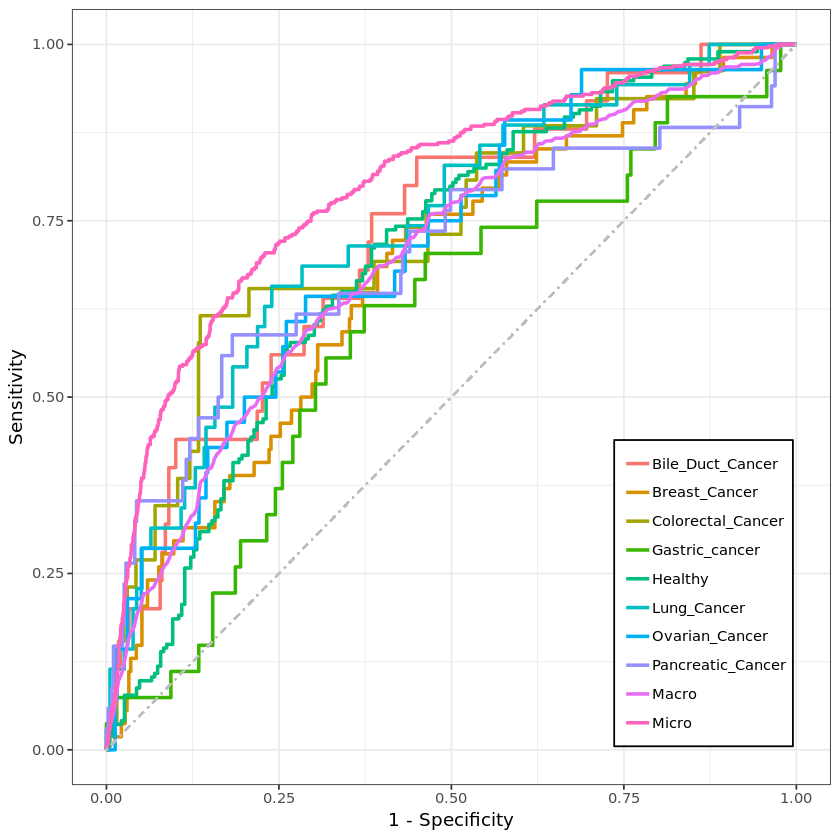

In [37]:
#perform multiroc and plot

roc_res <- multi_roc(final_df, force_diag=T)
plot_roc_df <- plot_roc_data(roc_res)
head(plot_roc_df)
dim(plot_roc_df)

ggplot(plot_roc_df, aes(x = 1-Specificity, y=Sensitivity)) +
  geom_path(aes(color = Group), size=1) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
                        colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5), 
                 legend.justification=c(1, 0), legend.position=c(.95, .05),
                 legend.title=element_blank(), 
                 legend.background = element_rect(fill=NULL, size=0.5, 
                                                           linetype="solid", colour ="black"))


In [38]:
# print AUCs
(AUCs <-roc_res$AUC %>%
  transpose() %>%
  as_tibble())

Bile_Duct_Cancer,Breast_Cancer,Colorectal_Cancer,Gastric_cancer,Healthy,Lung_Cancer,Ovarian_Cancer,Pancreatic_Cancer,macro,micro
0.7275377,0.6755495,0.7357101,0.6039095,0.6977671,0.739838,0.7124774,0.7011946,0.6992397,0.7992628


## Run the multiROC and plotting for all the CV repetitions

In [39]:
Specificities <- NULL
Sensitivities <- NULL

for (i in 1:k_outer_cv){
    res_CV <- data.frame(results %>% filter(CV_rep == i) %>% dplyr::select(-c(CV_rep, observed)))
    
    colnames(res_CV) <- paste(colnames(res_CV), "_pred_lasso", sep = "")

    true_label <- dummies::dummy(data$sample_type, sep = ".")
    true_label <- data.frame(true_label)
    colnames(true_label) <- gsub(".*?\\.", "", colnames(true_label))
    colnames(true_label) <- paste(colnames(true_label), "_true", sep = "")
    final_df <- cbind(true_label, res_CV)

    roc_res <- multi_roc(final_df, force_diag=T)
    
    if (i == 1){
        AUCs <- as.data.frame(t(unlist(roc_res$AUC)))
    }
    else {
        AUCs <- rbind(AUCs, as.data.frame(t(unlist(roc_res$AUC))))
    }
    
    plot_roc_df <- plot_roc_data(roc_res)
    plot_roc_df <- plot_roc_df %>% dplyr::select(-Method)
    
    if (i == 1){
        Specificities <- plot_roc_df %>% dplyr::select(Specificity)
        Sensitivities <- plot_roc_df %>% dplyr::select(Sensitivity)
        Groups  <- plot_roc_df %>% dplyr::select(Group)
    }
    else {
        Specificities <- cbind(Specificities, plot_roc_df %>% dplyr::select(Specificity))
        Sensitivities <- cbind(Sensitivities, plot_roc_df %>% dplyr::select(Sensitivity))
    }
    
    #IRdisplay::display(all_plot_roc_df)

}
Specificities <- tibble(Specificities, .name_repair = "unique")
Specificities <- Specificities %>% mutate(mean = rowMeans(across()))
Sensitivities <- tibble(Sensitivities, .name_repair = "unique")
Sensitivities <- Sensitivities %>% mutate(mean = rowMeans(across()))

(AUCs <- tibble(AUCs))

all_sensitivity_specificity <- tibble(Specificity = Specificities$mean, Sensitivity = Sensitivities$mean, Group = Groups$Group)
head(all_sensitivity_specificity)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“

lasso.Bile_Duct_Cancer,lasso.Breast_Cancer,lasso.Colorectal_Cancer,lasso.Gastric_cancer,lasso.Healthy,lasso.Lung_Cancer,lasso.Ovarian_Cancer,lasso.Pancreatic_Cancer,lasso.macro,lasso.micro
0.7275377,0.6755495,0.7357101,0.6039095,0.6977671,0.7398380,0.7124774,0.7011946,0.6992397,0.7992628
0.6684422,0.7024992,0.7367758,0.5692106,0.7188133,0.7573638,0.7887884,0.7025556,0.7055478,0.8046783
0.6885427,0.7004416,0.7045146,0.5551814,0.7009859,0.6857143,0.7631103,0.7052019,0.6879541,0.7936093
0.6895477,0.6618488,0.7178841,0.5983913,0.7065682,0.7443299,0.7745027,0.6758657,0.6961062,0.7990711
0.6742714,0.6968785,0.7147840,0.6043771,0.7238554,0.7392489,0.7540687,0.6921216,0.6999329,0.7996428
0.6881407,0.7204657,0.7914164,0.6253273,0.7106424,0.6824742,0.7365280,0.7082262,0.7078935,0.8019909
0.7088442,0.6920104,0.7282503,0.4768986,0.7345473,0.7781296,0.7091320,0.7095116,0.6921447,0.7971901
0.7345729,0.7158988,0.7811471,0.5362888,0.7244181,0.7914580,0.7727848,0.7261455,0.7228162,0.8121841
0.7401005,0.7097260,0.7173028,0.5552750,0.7102598,0.7115611,0.7388788,0.6909118,0.6967475,0.7951103
0.6828141,0.6966777,0.6793257,0.5329218,0.7184757,0.7662739,0.7613924,0.6719341,0.6887203,0.7957849


Specificity,Sensitivity,Group
1.0000000,0.000,Bile_Duct_Cancer
0.9977387,0.004,Bile_Duct_Cancer
0.9957286,0.012,Bile_Duct_Cancer
0.9937186,0.020,Bile_Duct_Cancer
0.9914573,0.024,Bile_Duct_Cancer
0.9896985,0.036,Bile_Duct_Cancer


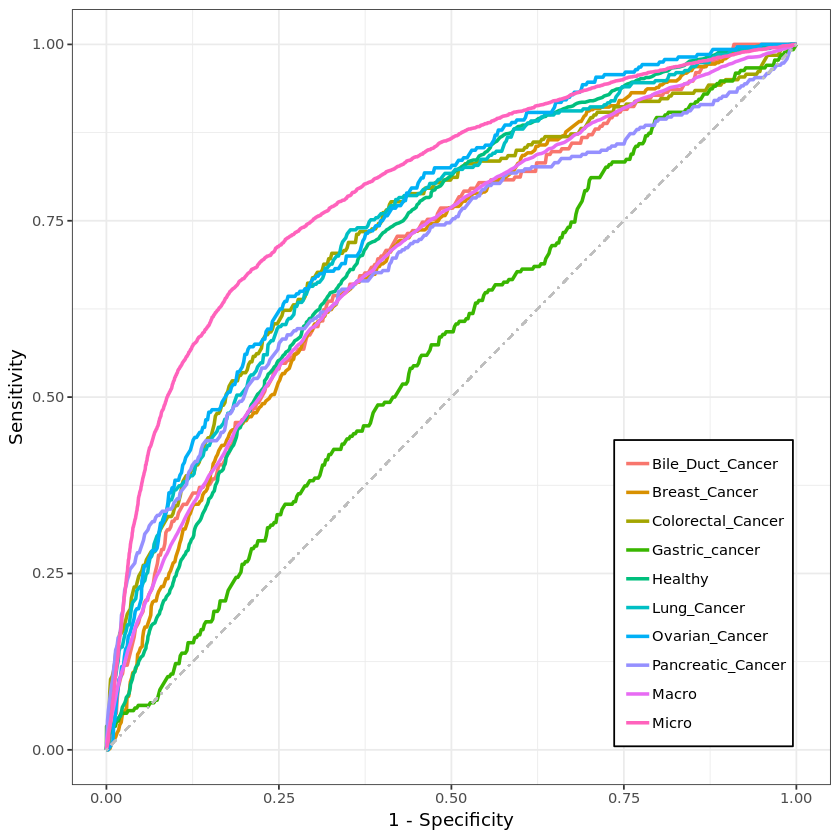

In [40]:
ggplot(all_sensitivity_specificity, aes(x = 1-Specificity, y=Sensitivity)) +
  geom_path(aes(color = Group), size=1) +
  geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1), 
                        colour='grey', linetype = 'dotdash') +
  theme_bw() + 
  theme(plot.title = element_text(hjust = 0.5), 
                 legend.justification=c(1, 0), legend.position=c(.95, .05),
                 legend.title=element_blank(), 
                 legend.background = element_rect(fill=NULL, size=0.5, 
                                                           linetype="solid", colour ="black"))

In [42]:
print("Mean AUC over 10 repetitions of 10-fold CV: ")
(mean_AUCs <- colMeans(AUCs[sapply(AUCs, is.numeric)]))

[1] "Mean AUC over 10 repetitions of 10-fold CV: "


lasso.Bile_Duct_Cancer     lasso.Breast_Cancer lasso.Colorectal_Cancer 
              0.7002814               0.6971996               0.7307111 
   lasso.Gastric_cancer           lasso.Healthy       lasso.Lung_Cancer 
              0.5657782               0.7146333               0.7396392 
   lasso.Ovarian_Cancer lasso.Pancreatic_Cancer             lasso.macro 
              0.7511664               0.6983669               0.6997103 
            lasso.micro 
              0.7998525

In [43]:
results01 <- tibble()

for (i in 1:k_outer_cv){
    res_CV <- results %>% filter(CV_rep == i)
    obs_rep <- res_CV %>% dplyr::select(c(CV_rep, observed))
    res_CV <- res_CV %>% dplyr::select(-c(CV_rep, observed))
    res_CV <- res_CV %>% mutate(pred01 = factor(colnames(res_CV)[apply(res_CV,1,which.max)], ordered = TRUE))
    res_CV <- cbind(res_CV, obs_rep)
    results01 <- rbind(results01, res_CV)
}

head(results01)

Gastric_cancer,Ovarian_Cancer,Lung_Cancer,Healthy,Bile_Duct_Cancer,Pancreatic_Cancer,Breast_Cancer,Colorectal_Cancer,pred01,CV_rep,observed
1.355055e-04,3.350624e-04,1.951443e-06,0.07215735,1.331574e-06,2.467616e-03,2.618548e-02,3.426147e-09,Healthy,1,Gastric_cancer
7.679557e-04,1.225125e-08,5.202109e-04,0.90744929,1.043617e-08,1.046783e-05,3.523956e-05,1.244277e-07,Healthy,1,Gastric_cancer
9.971083e-07,5.306996e-06,2.732940e-06,0.09856908,6.847001e-02,9.298745e-01,5.721901e-07,1.824309e-05,Pancreatic_Cancer,1,Gastric_cancer
2.406842e-04,1.070266e-06,3.426210e-05,0.98795817,1.151474e-07,5.756025e-07,3.076165e-04,1.023627e-04,Healthy,1,Gastric_cancer
2.075268e-05,2.328988e-03,1.649403e-02,0.63145035,4.334768e-07,8.511870e-06,1.469839e-02,5.328265e-06,Healthy,1,Ovarian_Cancer
4.670201e-06,9.545087e-01,3.118295e-06,0.85401848,7.805162e-04,1.067010e-03,4.490446e-04,1.414525e-10,Ovarian_Cancer,1,Ovarian_Cancer


In [44]:
error_rates <- c()
accuracies <- c()
for (i in 1:k_outer_cv){
    res_CV <- results01 %>% filter(CV_rep == i)
    error_rates <- c(error_rates, mean(as.character(res_CV$observed) != as.character(res_CV$pred01)))
    accuracies <- c(accuracies, mean(as.character(res_CV$observed) == as.character(res_CV$pred01)))
}

error_rates
accuracies

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")

[1] 0.5177305 0.4988180 0.5082742 0.5200946 0.5059102 0.4988180 0.5106383
 [8] 0.5059102 0.5248227 0.5082742

[1] 0.4822695 0.5011820 0.4917258 0.4799054 0.4940898 0.5011820 0.4893617
 [8] 0.4940898 0.4751773 0.4917258

[1] "Mean error rate over 10 repetitions of 10-fold CV: 0.509929078014184"

[1] "Mean accuracy over 10 repetitions of 10-fold CV: 0.490070921985816"